# 🏗️ Ajuste de Hiperparâmetros para Classificação Binária de Imagens - **Atividade Prática**


**Objetivo**: Executar um pipeline completo de classificação de imagens usando uma CNN, testando diferentes configurações de hiperparâmetros como **taxa de aprendizado** e **tamanho de lote**.


**Como usar**:

- Complete os trechos de código entre
```
### =============================================
### --------> Inicie seu código aqui <-----------
### =============================================
```
e
```
### =============================================
### ----------> Fim do seu código <--------------
### =============================================
```
- Você pode adicionar células extras para experimentação.
- O caminho está guiado: setup → carregamento do modelo → experimento com taxa de aprendizado variável → experimento com tamanho de lote variável → experimento com abordagens mistas → análise de performance e visualização de resultados.

## 📋 Fluxo do exercício

1. **Carregar o modelo e as imagens** no seu ambiente.
2. **Executar treinamentos** de experimentos com **hiperparâmetros** variáveis no modelo convolucional.
3. **Obter e visualizar** as classes após inferência no modelo convolucional.

---

### Referências

> [pytorch](https://docs.pytorch.org/docs/stable/index.html)
>
> [Deep Learning with PyTorch](https://github.com/matheuslevi11/Deep-Learning-With-Pytorch)

## ⚙️ Imports e configuração básica

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

Usando device: cuda


## 🖼️ Dataset e modelo

Aqui estamos carregando o dataset a ser usado ([CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)) e definindo o modelo, uma rede neural convolucional simples. Nessa atividade, iremos treinar esse modelo convolucional para classificar imagens desse dataset entre duas classes.

In [2]:
# Transformações e pré-processamento
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Usando CIFAR-10, classes 0 e 1 para classificação
full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
mask = (torch.tensor(full.targets) == 0) | (torch.tensor(full.targets) == 1) # Usando as classes 0 e 1
indices = torch.where(mask)[0].tolist()
subset = Subset(full, indices)
val_frac = 0.2
n_total = len(subset)
n_val = int(val_frac * n_total)
n_train = n_total - n_val
train_ds, val_ds = random_split(subset, [n_train, n_val])

# Separando dataset de teste
test_full = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
mask_t = (torch.tensor(test_full.targets) == 0) | (torch.tensor(test_full.targets) == 1)
indices_t = torch.where(mask_t)[0].tolist()
test_ds = Subset(test_full, indices_t)

# Definindo o modelo convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return total_loss / total, correct / total

def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    return total_loss / total, correct / total

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


## Parte 1 – 🔧 Hiperparâmetros na atividade

Nas partes **2a**, **2b** e **3** dessa atividade, você irá encontrar blocos de código semelhantes a esse abaixo, com os trechos de ``"Inicie seu código aqui"`` e ``"Fim do seu código"``. Preencha as variáveis dentro desses blocos de código com valores coerentes aprendidos em aula.

Em cada parte, há uma definição das variáveis, definidos abaixo:
* ``epochs`` é um valor inteiro
* ``batch size`` e ``learning rate`` : varia de acordo com a parte, podendo ser um valor fixo ou uma ``lista`` de valores.

Exemplos de variáveis fixas e de lista de valores:  
  ```python
  # Batch size fixo e learning rate variável
  batch_size = 10
  learning_rates = [0.03, 2, 5e-5, 1.1]
  ```

  ou
  ```python
  # Batch size variável e learning rate fixo
  batch_size = [10,16,32,100]
  learning_rate = 0.1
  ```

O conceito de "``batch size`` variável", por exemplo, envolve realizar treinos com cada um dos valores da lista. Por isso o termo "variável".

> **ATENÇÃO**: mesmo dentro de uma lista, o(s) valor(es) para ``batch size`` devem ser **inteiros**.

## Parte 2 – 🧪 Experimentos controlados

Você fará dois experimentos:
- 2a: variar taxa de aprendizado (*learning rate*), mantendo o valor do tamanho de lote (*batch size*) fixo.
- 2b: variar tamanho de lote (*batch size*), mantendo taxa de aprendizado (*learning rate*) fixo.


### Parte 2a – 💭 Variação de *learning rate* com *batch size* fixo

**TAREFA:** Selecionar os valores dos hiperparâmetros ``learning rate`` e ``batch size``.

* Preencha dentro do bloco de código entre **Inicie seu código aqui** e **Fim do seu código**.
* Preencha apenas as variáveis que estão como ``None`` ou ``[]``.
* Recomenda-se treinar por pelo menos 5 épocas.
* Na lista, coloque **2 valores**.

In [3]:
### =============================================
### --------> Inicie seu código aqui <-----------
### =============================================

learning_rates_p2a = [0.01, 0.001]
fixed_bs_p2a = 32
num_epochs_p2a = 8

### =============================================
### ----------> Fim do seu código <--------------
### =============================================

In [4]:
assert type(num_epochs_p2a) == int, "num_epochs_p2a deve ser um valor inteiro"
assert type(learning_rates_p2a) == list, "learning_rates_p2a deve ser uma lista"

In [5]:
results_p2a = []
print("=== Parte 2a: variar LR com BS fixo ===")
for lr in tqdm(learning_rates_p2a):
    tqdm.write("\n"+"---"*15)
    tqdm.write(f"learning rate = {lr:.1e}, batch size = {fixed_bs_p2a}")
    train_loader = DataLoader(train_ds, batch_size=fixed_bs_p2a, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=fixed_bs_p2a, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=fixed_bs_p2a, shuffle=False, num_workers=2)

    model = SimpleCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"lr": lr, "batch_size": fixed_bs_p2a, "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in tqdm(range(num_epochs_p2a)):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        tqdm.write(f" ep{epoch}: tr_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
    te_loss, te_acc = eval_one_epoch(model, test_loader, criterion)
    tqdm.write(f" → Test acc = {te_acc:.4f}")
    history["test_loss"] = te_loss
    history["test_acc"] = te_acc
    results_p2a.append(history)

=== Parte 2a: variar LR com BS fixo ===


  0%|          | 0/2 [00:00<?, ?it/s]


---------------------------------------------
learning rate = 1.0e-02, batch size = 32




 12%|█▎        | 1/8 [00:05<00:38,  5.51s/it]

 ep0: tr_acc=0.8016, val_acc=0.8500



 25%|██▌       | 2/8 [00:11<00:33,  5.51s/it]

 ep1: tr_acc=0.8570, val_acc=0.8675



 38%|███▊      | 3/8 [00:15<00:25,  5.10s/it]

 ep2: tr_acc=0.8806, val_acc=0.8790



 50%|█████     | 4/8 [00:21<00:21,  5.39s/it]

 ep3: tr_acc=0.8765, val_acc=0.8575



 62%|██████▎   | 5/8 [00:26<00:15,  5.15s/it]

 ep4: tr_acc=0.8931, val_acc=0.8955



 75%|███████▌  | 6/8 [00:30<00:10,  5.02s/it]

 ep5: tr_acc=0.9059, val_acc=0.8985



 88%|████████▊ | 7/8 [00:36<00:05,  5.23s/it]

 ep6: tr_acc=0.9126, val_acc=0.8935



100%|██████████| 8/8 [00:41<00:00,  5.15s/it]

 ep7: tr_acc=0.9064, val_acc=0.8935



 50%|█████     | 1/2 [00:42<00:42, 42.45s/it]

 → Test acc = 0.8815

---------------------------------------------
learning rate = 1.0e-03, batch size = 32




 12%|█▎        | 1/8 [00:05<00:40,  5.81s/it]

 ep0: tr_acc=0.8383, val_acc=0.8975



 25%|██▌       | 2/8 [00:10<00:30,  5.10s/it]

 ep1: tr_acc=0.9044, val_acc=0.9160



 38%|███▊      | 3/8 [00:15<00:24,  4.92s/it]

 ep2: tr_acc=0.9244, val_acc=0.9220



 50%|█████     | 4/8 [00:20<00:20,  5.25s/it]

 ep3: tr_acc=0.9404, val_acc=0.9230



 62%|██████▎   | 5/8 [00:25<00:14,  4.99s/it]

 ep4: tr_acc=0.9520, val_acc=0.9175



 75%|███████▌  | 6/8 [00:31<00:10,  5.20s/it]

 ep5: tr_acc=0.9621, val_acc=0.9210



 88%|████████▊ | 7/8 [00:35<00:04,  4.98s/it]

 ep6: tr_acc=0.9735, val_acc=0.9410



100%|██████████| 8/8 [00:40<00:00,  5.02s/it]

 ep7: tr_acc=0.9796, val_acc=0.9385



100%|██████████| 2/2 [01:23<00:00, 41.90s/it]

 → Test acc = 0.9245


### Parte 2b – 📦 Variação de *batch size* com *learning rate* fixo

**TAREFA:** Selecionar os valores dos hiperparâmetros ``learning rate`` e ``batch size``.

* Preencha dentro do bloco de código entre **Inicie seu código aqui** e **Fim do seu código**.
* Preencha apenas as variáveis que estão como ``None`` ou ``[]``.
* Recomenda-se treinar por pelo menos 5 épocas.
* Na lista, coloque **2 valores**.

In [6]:
### =============================================
### --------> Inicie seu código aqui <-----------
### =============================================

fixed_lr_p2b = 0.001
batch_sizes_p2b = [32, 64]
num_epochs_p2b = 8

### =============================================
### ----------> Fim do seu código <--------------
### =============================================

In [7]:
assert type(num_epochs_p2b) == int, "num_epochs_p2b deve ser um valor inteiro"
assert type(batch_sizes_p2b) == list, "batch_sizes_p2b deve ser uma lista"

In [8]:
results_p2b = []
print("=== Parte 2b: variar BS com LR fixo ===")
for bs in tqdm(batch_sizes_p2b):
    tqdm.write("\n"+"---"*15)
    tqdm.write(f"batch size = {bs}, learning rate = {fixed_lr_p2b:.1e}")
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=2)

    model = SimpleCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=fixed_lr_p2b)

    history = {"lr": fixed_lr_p2b, "batch_size": bs, "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in tqdm(range(num_epochs_p2b)):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        tqdm.write(f" ep{epoch}: tr_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
    te_loss, te_acc = eval_one_epoch(model, test_loader, criterion)
    tqdm.write(f" → Test acc = {te_acc:.4f}")
    history["test_loss"] = te_loss
    history["test_acc"] = te_acc
    results_p2b.append(history)

=== Parte 2b: variar BS com LR fixo ===


  0%|          | 0/2 [00:00<?, ?it/s]


---------------------------------------------
batch size = 32, learning rate = 1.0e-03




 12%|█▎        | 1/8 [00:05<00:39,  5.68s/it]

 ep0: tr_acc=0.8164, val_acc=0.8635



 25%|██▌       | 2/8 [00:10<00:30,  5.15s/it]

 ep1: tr_acc=0.8836, val_acc=0.8990



 38%|███▊      | 3/8 [00:15<00:25,  5.02s/it]

 ep2: tr_acc=0.9120, val_acc=0.9080



 50%|█████     | 4/8 [00:20<00:20,  5.13s/it]

 ep3: tr_acc=0.9333, val_acc=0.9195



 62%|██████▎   | 5/8 [00:25<00:14,  4.94s/it]

 ep4: tr_acc=0.9489, val_acc=0.9110



 75%|███████▌  | 6/8 [00:30<00:10,  5.20s/it]

 ep5: tr_acc=0.9616, val_acc=0.9225



 88%|████████▊ | 7/8 [00:35<00:04,  4.98s/it]

 ep6: tr_acc=0.9699, val_acc=0.9275



100%|██████████| 8/8 [00:40<00:00,  5.02s/it]

 ep7: tr_acc=0.9832, val_acc=0.9395



 50%|█████     | 1/2 [00:41<00:41, 41.76s/it]

 → Test acc = 0.9340

---------------------------------------------
batch size = 64, learning rate = 1.0e-03




 12%|█▎        | 1/8 [00:04<00:31,  4.49s/it]

 ep0: tr_acc=0.8217, val_acc=0.8695



 25%|██▌       | 2/8 [00:08<00:25,  4.24s/it]

 ep1: tr_acc=0.8860, val_acc=0.8830



 38%|███▊      | 3/8 [00:13<00:23,  4.63s/it]

 ep2: tr_acc=0.9071, val_acc=0.8990



 50%|█████     | 4/8 [00:17<00:17,  4.43s/it]

 ep3: tr_acc=0.9297, val_acc=0.9180



 62%|██████▎   | 5/8 [00:21<00:13,  4.34s/it]

 ep4: tr_acc=0.9369, val_acc=0.9260



 75%|███████▌  | 6/8 [00:27<00:09,  4.66s/it]

 ep5: tr_acc=0.9494, val_acc=0.9285



 88%|████████▊ | 7/8 [00:31<00:04,  4.53s/it]

 ep6: tr_acc=0.9591, val_acc=0.9275



100%|██████████| 8/8 [00:35<00:00,  4.46s/it]

 ep7: tr_acc=0.9650, val_acc=0.9120



100%|██████████| 2/2 [01:18<00:00, 39.19s/it]

 → Test acc = 0.9125


## Parte 3 – 🧩 Experimentos combinados / refinamento

**TAREFA:** Selecionar os valores dos hiperparâmetros ``learning rate`` e ``batch size``.

* Preencha dentro do bloco de código entre **Inicie seu código aqui** e **Fim do seu código**.
* Preencha apenas a variável que está como ``[]``.
* Dentro da lista ``[]``, coloque 2 ``sets`` correspondendo a ``(learning rate, batch size)``
  * Por exemplo, ```[(0.04, 200), (1.3, 16)]```

In [9]:
### =============================================
### --------> Inicie seu código aqui <-----------
### =============================================

lr_bs_pairs_p3 = [(0.001, 32), (0.01, 64)]
num_epochs_p3 = 8

### =============================================
### ----------> Fim do seu código <--------------
### =============================================

In [10]:
assert type(num_epochs_p3) == int, "num_epochs_p3 deve ser um valor inteiro"
assert type(lr_bs_pairs_p3) == list, "lr_bs_pairs_p3 deve ser uma lista de tuplas"

In [11]:
results_p3 = []
print("=== Parte 3: experimentos combinados / refinamento ===")
separator = "\n" + "---"*15
for (lr, bs) in tqdm(lr_bs_pairs_p3):
    tqdm.write(separator)
    tqdm.write(f"learning rate = {lr:.1e}, batch size = {bs}")
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=2)

    model = SimpleCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"lr": lr, "batch_size": bs, "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in tqdm(range(num_epochs_p3)):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        tqdm.write(f" ep{epoch}: tr_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
    te_loss, te_acc = eval_one_epoch(model, test_loader, criterion)
    tqdm.write(f" → Test acc = {te_acc:.4f}")
    history["test_loss"] = te_loss
    history["test_acc"] = te_acc
    results_p3.append(history)

=== Parte 3: experimentos combinados / refinamento ===


  0%|          | 0/2 [00:00<?, ?it/s]


---------------------------------------------
learning rate = 1.0e-03, batch size = 32



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:07<00:54,  7.80s/it]

 ep0: tr_acc=0.8481, val_acc=0.8525




 25%|██▌       | 2/8 [00:13<00:39,  6.59s/it]

 ep1: tr_acc=0.8990, val_acc=0.9120




 38%|███▊      | 3/8 [00:18<00:28,  5.71s/it]

 ep2: tr_acc=0.9266, val_acc=0.9220




 50%|█████     | 4/8 [00:23<00:21,  5.41s/it]

 ep3: tr_acc=0.9373, val_acc=0.9230




 62%|██████▎   | 5/8 [00:28<00:16,  5.39s/it]

 ep4: tr_acc=0.9489, val_acc=0.9265




 75%|███████▌  | 6/8 [00:33<00:10,  5.10s/it]

 ep5: tr_acc=0.9559, val_acc=0.9220




 88%|████████▊ | 7/8 [00:38<00:05,  5.30s/it]

 ep6: tr_acc=0.9605, val_acc=0.9255




100%|██████████| 8/8 [00:43<00:00,  5.42s/it]

 ep7: tr_acc=0.9732, val_acc=0.9255



 50%|█████     | 1/2 [00:44<00:44, 44.35s/it]

 → Test acc = 0.9345

---------------------------------------------
learning rate = 1.0e-02, batch size = 64



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:05<00:38,  5.52s/it]

 ep0: tr_acc=0.6907, val_acc=0.8150




 25%|██▌       | 2/8 [00:09<00:28,  4.83s/it]

 ep1: tr_acc=0.8492, val_acc=0.8475




 38%|███▊      | 3/8 [00:14<00:22,  4.53s/it]

 ep2: tr_acc=0.8748, val_acc=0.8810




 50%|█████     | 4/8 [00:19<00:19,  4.80s/it]

 ep3: tr_acc=0.8888, val_acc=0.8715




 62%|██████▎   | 5/8 [00:23<00:13,  4.61s/it]

 ep4: tr_acc=0.8951, val_acc=0.8730




 75%|███████▌  | 6/8 [00:27<00:08,  4.47s/it]

 ep5: tr_acc=0.9059, val_acc=0.8800




 88%|████████▊ | 7/8 [00:33<00:04,  4.77s/it]

 ep6: tr_acc=0.9174, val_acc=0.8925




100%|██████████| 8/8 [00:37<00:00,  4.73s/it]

 ep7: tr_acc=0.9234, val_acc=0.8880



100%|██████████| 2/2 [01:23<00:00, 41.53s/it]

 → Test acc = 0.8800


## Parte 4 – 🔍 Visualização das inferências em imagens do teste

**TAREFA:** Selecionar qual configuração de ``(learning rate, batch_size)`` será usada na visualização final do modelo.

* Preencha dentro do bloco de código entre **Inicie seu código aqui** e **Fim do seu código**.
* Preencha apenas a variável que está como ``None``.

In [12]:
### =============================================
### --------> Inicie seu código aqui <-----------
### =============================================

i = 0 # "i" pode ser 0 ou 1

### =============================================
### ----------> Fim do seu código <--------------
### =============================================

best_lr, best_bs = lr_bs_pairs_p3[i]

Treinando modelo final com learning rate = 0.001 batch size = 32


Epocas:: 100%|██████████| 8/8 [00:40<00:00,  5.05s/it]


Definindo funções para visualização


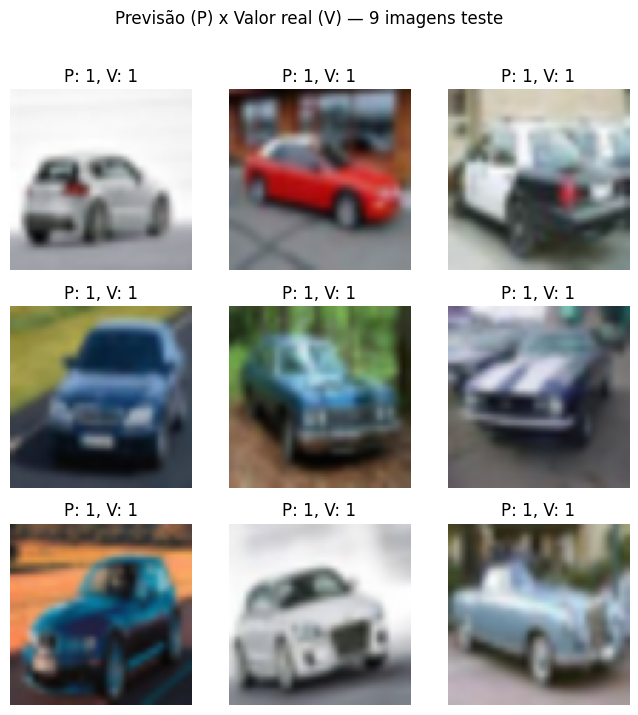

In [13]:
# Instanciando o modelo
final_model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_lr)

# Definindo o dataset para treino e teste
final_loader = DataLoader(train_ds, batch_size=best_bs, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=best_bs, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=best_bs, shuffle=False, num_workers=2)

print("Treinando modelo final com learning rate =", best_lr, "batch size =", best_bs)
for epoch in tqdm(range(num_epochs_p3), desc="Epocas:"):
    _ = train_one_epoch(final_model, final_loader, criterion, optimizer)
    _ = eval_one_epoch(final_model, val_loader, criterion)

print("Definindo funções para visualização")
def imshow(img_tensor):
    img = img_tensor.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    return img

indices_vis = random.sample(range(len(test_ds)), 9)

# Visualizando os resultados após o treinamento
plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices_vis):
    img, true_label = test_ds[idx]
    img_input = img.to(device).unsqueeze(0)
    with torch.no_grad():
        out = final_model(img_input)
        pred = (out >= 0.5).float().item()
    img_np = imshow(img)
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f"P: {int(pred)}, V: {int(true_label)}")
plt.suptitle("Previsão (P) x Valor real (V) — 9 imagens teste")
plt.show()

## (Opcional) Parte 5 – 📊 Cálculo de desempenho do modelo

**TAREFA:** Calcular acurácia, precisão e recall de um modelo treinado.

* Preencha dentro do bloco de código entre **Inicie seu código aqui** e **Fim do seu código**.
* Preencha apenas a variável que está como ``None``.

### DICA IMPORTANTE: Como usar np.sum() com condições

A técnica `np.sum((array == valor) & (outro_array == outro_valor))` é muito útil:

```python
# Exemplo prático:
predicoes = np.array([1, 0, 1, 0, 1])
labels = np.array([1, 0, 0, 1, 1])

# Contar Verdadeiros Positivos (predição=1 E label=1)
tp = np.sum((predicoes == 1) & (labels == 1))  # Resultado: 2

# Como funciona:
# (predicoes == 1) retorna: [True, False, True, False, True]
# (labels == 1) retorna:    [True, False, False, True, True]
# & faz AND lógico:         [True, False, False, False, True]
# np.sum() conta os True:   2
```

In [14]:
# Variáveis para armazenar as predições e labels verdadeiros
all_predictions = []
all_labels = []

# Coloque o modelo em modo de avaliação
final_model.eval()

# Obter todas as predições do conjunto de teste
with torch.no_grad():
    for images, labels in test_loader:
        # Mova as imagens para o device
        images = images.to(device)
        labels = labels.to(device)

        # Obtenha as predições do modelo
        outputs = final_model(images)

        # Converta as predições para classes (0 ou 1)
        predictions = (outputs >= 0.5).float().squeeze()

        # Armazene as predições e labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Converta para arrays numpy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# =============================================
# --------> Inicie seu código aqui <-----------
# =============================================

# Calcular matriz de confusão
# Verdadeiros Positivos (TP): Predição = 1, Label = 1
tp = np.sum((all_predictions == 1) & (all_labels == 1))

# Falsos Positivos (FP): Predição = 1, Label = 0
fp = np.sum((all_predictions == 1) & (all_labels == 0))

# Verdadeiros Negativos (TN): Predição = 0, Label = 0
tn = np.sum((all_predictions == 0) & (all_labels == 0))

# Falsos Negativos (FN): Predição = 0, Label = 1
fn = np.sum((all_predictions == 0) & (all_labels == 1))

# Calcular as métricas
# Acurácia: (TP + TN) / (Total de Amostras)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Precisão: TP / (Total de Predições Positivas)
precision = tp / (tp + fp)

# Recall: TP / (Total de Labels Realmente Positivos)
recall = tp / (tp + fn)

# =============================================
# ----------> Fim do seu código <----------
# =============================================



In [15]:
# Exibindo a matriz de confusão
print("=" * 60)
print("MATRIZ DE CONFUSÃO")
print("=" * 60)
print(f"Verdadeiros Positivos (TP):  {tp:4d}")
print(f"Falsos Positivos (FP):       {fp:4d}")
print(f"Verdadeiros Negativos (TN):  {tn:4d}")
print(f"Falsos Negativos (FN):       {fn:4d}")
print(f"Total de amostras:           {tp + fp + tn + fn:4d}")
print("=" * 60)

# Exibindo os resultados das métricas
print("\nRESULTADOS DO DESEMPENHO DO MODELO")
print("=" * 60)
print(f"Acurácia:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precisão:  {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print("=" * 60)

# Interpretação dos resultados
print("\nINTERPRETAÇÃO:")
if accuracy >= 0.8:
    print("Excelente! O modelo tem alta acurácia.")
elif accuracy >= 0.7:
    print("Bom! O modelo tem boa acurácia.")
elif accuracy >= 0.6:
    print("Razoável. O modelo pode ser melhorado.")
else:
    print("Baixo desempenho. Considere ajustar hiperparâmetros ou arquitetura.")

if precision >= 0.8:
    print("Alta precisão: poucos falsos positivos.")
elif precision >= 0.6:
    print("Boa precisão.")
else:
    print("Baixa precisão: muitos falsos positivos.")

if recall >= 0.8:
    print("Alto recall: poucos falsos negativos.")
elif recall >= 0.6:
    print("Bom recall.")
else:
    print("Baixo recall: muitos falsos negativos.")

# Cálculo do F1-Score (métrica adicional)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"\nF1-Score:   {f1_score:.4f} ({f1_score*100:.2f}%)")

print("\n" + "=" * 60)
print("Cálculo de desempenho concluído!")
print("=" * 60)


MATRIZ DE CONFUSÃO
Verdadeiros Positivos (TP):   960
Falsos Positivos (FP):         97
Verdadeiros Negativos (TN):   903
Falsos Negativos (FN):         40
Total de amostras:           2000

RESULTADOS DO DESEMPENHO DO MODELO
Acurácia:  0.9315 (93.15%)
Precisão:  0.9082 (90.82%)
Recall:    0.9600 (96.00%)

INTERPRETAÇÃO:
Excelente! O modelo tem alta acurácia.
Alta precisão: poucos falsos positivos.
Alto recall: poucos falsos negativos.

F1-Score:   0.9334 (93.34%)

Cálculo de desempenho concluído!
